<a href="https://colab.research.google.com/github/spindouken/holbertonschool-machine_learning/blob/master/supervised_learning/object_detection/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount your google drive (can click on folder with google drive icon in folder navigation bar).Upload data to my drive in new folder 'data' if you haven't already. Note: you can right click the files to the left and select 'copy path', then paste that path inside the main files (before the actual file name being used)

This colab book has edited main files to allow visualization on colab (due to compatability issues). The yolo files are unaffected (not edited specifically for colab use).

# TASK 0 (Initialize Yolo class)

In [ ]:
#!/usr/bin/env python3
"""
uses the Yolo v3 algorithm to perform object detection
"""
import tensorflow.keras as K


class Yolo:
    """Yolo class"""

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used
            for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score threshold
            for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        anchors is a numpy.ndarray of shape (outputs, anchor_boxes, 2)
        ...containing all of the anchor boxes:
            outputs is the number of outputs (predictions)
                made by the Darknet model
            anchor_boxes is the number of anchor boxes used for each prediction
            2 => [anchor_box_width, anchor_box_height]
        Public instance attributes:
        model: the Darknet Keras model
        class_names: a list of the class names for the model
        class_t: the box score threshold for the initial filtering step
        nms_t: the IOU threshold for non-max suppression
        anchors: the anchor boxes
        """
        self.model = K.models.load_model(model_path)
        with open(classes_path, "r") as f:
            self.class_names = [line.strip() for line in f.readlines()]
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors


In [ ]:
#!/usr/bin/env python3

if __name__ == '__main__':
    import numpy as np

    np.random.seed(0)
    anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
    yolo = Yolo('/content/drive/MyDrive/data/yolo.h5', '/content/drive/MyDrive/data/coco_classes.txt', 0.6, 0.5, anchors)
    yolo.model.summary()
    print('Class names:', yolo.class_names)
    print('Class threshold:', yolo.class_t)
    print('NMS threshold:', yolo.nms_t)
    print('Anchor boxes:', yolo.anchors)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 416, 416, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# *TASK* 1 (Process outputs from Darknet model)

In [ ]:
#!/usr/bin/env python3
"""
uses the Yolo v3 algorithm to perform object detection
"""
import tensorflow as tf
import numpy as np


class Yolo:
    """Yolo class to perform object detection using the YOLOv3 algorithm"""

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used
            for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score
            threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        anchors is a numpy.ndarray of shape (outputs, anchor_boxes, 2)
            ...containing all of the anchor boxes:
            outputs is the number of outputs (predictions)
                made by the Darknet model
            anchor_boxes is the number of anchor boxes used for each prediction
            2 => [anchor_box_width, anchor_box_height]
        Public instance attributes:
        model: the Darknet Keras model
        class_names: a list of the class names for the model
        class_t: the box score threshold for the initial filtering step
        nms_t: the IOU threshold for non-max suppression
        anchors: the anchor boxes
        """
        if not tf.keras.models.load_model(model_path):
            raise FileNotFoundError("Model not found at the provided path.")
        if not isinstance(anchors, np.ndarray) or anchors.shape[-1] != 2:
            raise ValueError(
                "Anchors must be a numpy.ndarray \
                of shape (outputs, anchor_boxes, 2)."
            )

        self.model = tf.keras.models.load_model(model_path)
        with open(classes_path, "r") as f:
            self.class_names = [line.strip() for line in f.readlines()]
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors

    def process_outputs(self, outputs, image_size):
        """
        Processes the outputs from the Darknet model for a single image.
        The nested loops iterate through each grid cell and anchor box to
            compute the processed boundary box coordinates.
        The loops handle the conversion of coordinates from the
            Darknet model's prediction to the
            coordinates relative to the original image.

        outputs: contains predictions from Darknet model for a single image
        i: used to access the corresponding anchor box dimensions
        output: the individual prediction array for processing

        :param outputs: list of numpy.ndarrays containing
            the predictions from the Darknet model for a single image
                Each output will have the shape (grid_height,
                    grid_width, anchor_boxes, 4 + 1 + classes),
                where:
                    - grid_height & grid_width: height
                        and width of the grid used for the output
                    - anchor_boxes: number of anchor boxes used
                    - 4: bounding box coordinates (t_x, t_y, t_w, t_h)
                    - 1: box_confidence
                    - classes: class probabilities for all classes
        :param image_size: numpy.ndarray containing the image’s
            original size [image_height, image_width]
        :return: tuple of (boxes, box_confidences, box_class_probs)
                - boxes: list of numpy.ndarrays of shape (grid_height,
                    grid_width, anchor_boxes, 4) containing the processed
                    boundary boxes for each output, respectively
                4 => (x1, y1, x2, y2) representing
                    the boundary box relative to original image
                - box_confidences: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, 1)
                    containing the box confidences for each output
                - box_class_probs: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, classes)
                    containing the box’s class probabilities for each output
        """
        boxes = []
        box_confidences = []
        box_class_probs = []

        for output_index, output in enumerate(outputs):
            grid_height, grid_width, anchor_boxes, _ = output.shape
            raw_boundary_box_coords = output[..., :4]
            rawBoxConfidence = output[..., 4:5]
            raw_box_class_probabilities = output[..., 5:]

            # Applying sigmoid activation to the box confidence
            box_confidence_after_sigmoid = 1 / (1 + np.exp(-rawBoxConfidence))
            box_confidences.append(box_confidence_after_sigmoid)

            # Applying sigmoid activation to the class probabilities
            box_class_probs_after_sigmoid = 1 / (
                1 + np.exp(-raw_box_class_probabilities)
            )
            box_class_probs.append(box_class_probs_after_sigmoid)

            for cell_y in range(grid_height):
                for cell_x in range(grid_width):
                    for anchor_box_index in range(anchor_boxes):
                        anchor_width, anchor_height = self.anchors[
                            output_index
                        ][anchor_box_index]
                        tx, ty, tw, th = raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ]

                        # Applying sigmoid activation and
                        #   offsetting by grid cell location
                        boundaryBoxCenter_x = (1 / (1 + np.exp(-tx))) + cell_x
                        boundaryBoxCenter_y = (1 / (1 + np.exp(-ty))) + cell_y

                        # Applying exponential and scaling by anchor dimensions
                        boundary_box_width = anchor_width * np.exp(tw)
                        boundary_box_height = anchor_height * np.exp(th)

                        # Normalizing by grid and model input dimensions
                        boundaryBoxCenter_x /= grid_width
                        boundaryBoxCenter_y /= grid_height
                        boundary_box_width /= int(self.model.input.shape[1])
                        boundary_box_height /= int(self.model.input.shape[2])

                        # Converting to original image scale
                        top_left_x = (
                            boundaryBoxCenter_x - (boundary_box_width / 2)
                        ) * image_size[1]
                        top_left_y = (
                            boundaryBoxCenter_y - (boundary_box_height / 2)
                        ) * image_size[0]
                        bottom_right_x = (
                            boundaryBoxCenter_x + (boundary_box_width / 2)
                        ) * image_size[1]
                        bottom_right_y = (
                            boundaryBoxCenter_y + (boundary_box_height / 2)
                        ) * image_size[0]

                        # Storing the processed boundary box coordinates
                        raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ] = [
                            top_left_x,
                            top_left_y,
                            bottom_right_x,
                            bottom_right_y,
                        ]

            boxes.append(raw_boundary_box_coords)

        return (boxes, box_confidences, box_class_probs)


In [ ]:
#!/usr/bin/env python3

if __name__ == '__main__':
    import numpy as np

    np.random.seed(0)
    anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
    yolo = Yolo('/content/drive/MyDrive/data/yolo.h5', '/content/drive/MyDrive/data/coco_classes.txt', 0.6, 0.5, anchors)
    output1 = np.random.randn(13, 13, 3, 85)
    output2 = np.random.randn(26, 26, 3, 85)
    output3 = np.random.randn(52, 52, 3, 85)
    boxes, box_confidences, box_class_probs = yolo.process_outputs([output1, output2, output3], np.array([500, 700]))
    print('Boxes:', boxes)
    print('Box confidences:', box_confidences)
    print('Box class probabilities:', box_class_probs)


Boxes: [array([[[[-2.13743365e+02, -4.85478868e+02,  3.05682061e+02,
           5.31534670e+02],
         [-6.28222336e+01, -1.13713822e+01,  1.56452678e+02,
           7.01966357e+01],
         [-7.00753664e+02, -7.99011810e+01,  7.77777040e+02,
           1.24440730e+02]],

        [[ 6.52921110e+01,  1.43688377e+00,  1.14233396e+02,
           2.36524697e+01],
         [ 2.79501974e+01, -2.03937627e+01,  1.59898932e+02,
           5.02826906e+01],
         [ 6.17629106e+01, -8.31889643e+01,  1.02303202e+02,
           1.38551621e+02]],

        [[ 1.20166765e+02,  2.31461495e+01,  1.71676644e+02,
           3.82523882e+01],
         [ 3.39847297e+01, -3.21481177e+01,  2.45335593e+02,
           6.17333839e+01],
         [-5.41077407e+02, -4.37386113e+02,  7.94834201e+02,
           4.95448229e+02]],

        ...,

        [[ 4.37830908e+02, -1.12792212e+02,  6.59360033e+02,
           1.26273767e+02],
         [ 4.40039718e+02, -1.34968536e+02,  6.70734974e+02,
           1.75141946

# TASK 2 (Filter Boxes)

In [ ]:
#!/usr/bin/env python3
"""
uses the Yolo v3 algorithm to perform object detection
"""
import tensorflow as tf
import numpy as np


class Yolo:
    """Yolo class to perform object detection using the YOLOv3 algorithm"""

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used
            for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score
            threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        anchors is a numpy.ndarray of shape (outputs, anchor_boxes, 2)
            ...containing all of the anchor boxes:
            outputs is the number of outputs (predictions)
                made by the Darknet model
            anchor_boxes is the number of anchor boxes used for each prediction
            2 => [anchor_box_width, anchor_box_height]
        Public instance attributes:
        model: the Darknet Keras model
        class_names: a list of the class names for the model
        class_t: the box score threshold for the initial filtering step
        nms_t: the IOU threshold for non-max suppression
        anchors: the anchor boxes
        """
        if not tf.keras.models.load_model(model_path):
            raise FileNotFoundError("Model not found at the provided path.")
        if not isinstance(anchors, np.ndarray) or anchors.shape[-1] != 2:
            raise ValueError(
                "Anchors must be a numpy.ndarray \
                of shape (outputs, anchor_boxes, 2)."
            )

        self.model = tf.keras.models.load_model(model_path)
        with open(classes_path, "r") as f:
            self.class_names = [line.strip() for line in f.readlines()]
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors

    def process_outputs(self, outputs, image_size):
        """
        Processes the outputs from the Darknet model for a single image.
        The nested loops iterate through each grid cell and anchor box to
            compute the processed boundary box coordinates.
        The loops handle the conversion of coordinates from the
            Darknet model's prediction to the
            coordinates relative to the original image.

        outputs: contains predictions from Darknet model for a single image
        i: used to access the corresponding anchor box dimensions
        output: the individual prediction array for processing

        :param outputs: list of numpy.ndarrays containing
            the predictions from the Darknet model for a single image
                Each output will have the shape (grid_height,
                    grid_width, anchor_boxes, 4 + 1 + classes),
                where:
                    - grid_height & grid_width: height
                        and width of the grid used for the output
                    - anchor_boxes: number of anchor boxes used
                    - 4: bounding box coordinates (t_x, t_y, t_w, t_h)
                    - 1: box_confidence
                    - classes: class probabilities for all classes
        :param image_size: numpy.ndarray containing the image’s
            original size [image_height, image_width]
        :return: tuple of (boxes, box_confidences, box_class_probs)
                - boxes: list of numpy.ndarrays of shape (grid_height,
                    grid_width, anchor_boxes, 4) containing the processed
                    boundary boxes for each output, respectively
                4 => (x1, y1, x2, y2) representing
                    the boundary box relative to original image
                - box_confidences: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, 1)
                    containing the box confidences for each output
                - box_class_probs: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, classes)
                    containing the box’s class probabilities for each output
        """
        boxes = []
        box_confidences = []
        box_class_probs = []

        for output_index, output in enumerate(outputs):
            grid_height, grid_width, anchor_boxes, _ = output.shape
            raw_boundary_box_coords = output[..., :4]
            rawBoxConfidence = output[..., 4:5]
            raw_box_class_probabilities = output[..., 5:]

            # Applying sigmoid activation to the box confidence
            box_confidence_after_sigmoid = 1 / (1 + np.exp(-rawBoxConfidence))
            box_confidences.append(box_confidence_after_sigmoid)

            # Applying sigmoid activation to the class probabilities
            box_class_probs_after_sigmoid = 1 / (
                1 + np.exp(-raw_box_class_probabilities)
            )
            box_class_probs.append(box_class_probs_after_sigmoid)

            for cell_y in range(grid_height):
                for cell_x in range(grid_width):
                    for anchor_box_index in range(anchor_boxes):
                        anchor_width, anchor_height = self.anchors[
                            output_index
                        ][anchor_box_index]
                        tx, ty, tw, th = raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ]

                        # Applying sigmoid activation and
                        #   offsetting by grid cell location
                        boundaryBoxCenter_x = (1 / (1 + np.exp(-tx))) + cell_x
                        boundaryBoxCenter_y = (1 / (1 + np.exp(-ty))) + cell_y

                        # Applying exponential and scaling by anchor dimensions
                        boundary_box_width = anchor_width * np.exp(tw)
                        boundary_box_height = anchor_height * np.exp(th)

                        # Normalizing by grid and model input dimensions
                        boundaryBoxCenter_x /= grid_width
                        boundaryBoxCenter_y /= grid_height
                        boundary_box_width /= int(self.model.input.shape[1])
                        boundary_box_height /= int(self.model.input.shape[2])

                        # Converting to original image scale
                        top_left_x = (
                            boundaryBoxCenter_x - (boundary_box_width / 2)
                        ) * image_size[1]
                        top_left_y = (
                            boundaryBoxCenter_y - (boundary_box_height / 2)
                        ) * image_size[0]
                        bottom_right_x = (
                            boundaryBoxCenter_x + (boundary_box_width / 2)
                        ) * image_size[1]
                        bottom_right_y = (
                            boundaryBoxCenter_y + (boundary_box_height / 2)
                        ) * image_size[0]

                        # Storing the processed boundary box coordinates
                        raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ] = [
                            top_left_x,
                            top_left_y,
                            bottom_right_x,
                            bottom_right_y,
                        ]

            boxes.append(raw_boundary_box_coords)

        return (boxes, box_confidences, box_class_probs)

    def filter_boxes(self, boxes, box_confidences, box_class_probs):
        """
        boxes: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, 4)
            containing processed boundary boxes for each output, respectively
        box_confidences: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, 1)
            containing processed box confidences for each output, respectively
        box_class_probs: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, classes)
            containing processed box class probabilities for each output

        Returns a tuple of (filtered_boxes, box_classes, box_scores):
            filtered_boxes: a numpy.ndarray of shape (?, 4)
                containing all of the filtered bounding boxes
            box_classes: a numpy.ndarray of shape (?,)
                containing the class number that each box
                in filtered_boxes predicts, respectively
            box_scores: a numpy.ndarray of shape (?)
                containing the box scores for each box
                in filtered_boxes, respectively
        """
        filtered_boxes = []
        box_classes = []
        box_scores = []

        # Iterate through each output
        for box, box_confidence, box_class_prob in zip(
            boxes, box_confidences, box_class_probs
        ):
            # Compute box scores by multiplying confidence w/ class probs
            scores = box_confidence * box_class_prob

            # Get the class index with the maximum score for each box
            box_class_indices = np.argmax(scores, axis=-1)
            box_class_scores = np.max(scores, axis=-1)

            # Create a mask for scores greater than the threshold
            filtering_mask = box_class_scores >= self.class_t

            # Apply the mask to filter the boxes, class indices, and scores
            filtered_boxes.append(box[filtering_mask])
            box_classes.append(box_class_indices[filtering_mask])
            box_scores.append(box_class_scores[filtering_mask])

        # Concatenate results from all outputs into single arrays
        filtered_boxes = np.concatenate(filtered_boxes)
        box_classes = np.concatenate(box_classes)
        box_scores = np.concatenate(box_scores)

        return (filtered_boxes, box_classes, box_scores)


In [ ]:
#!/usr/bin/env python3

if __name__ == '__main__':
    import numpy as np

    np.random.seed(0)
    anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
    yolo = Yolo('/content/drive/MyDrive/data/yolo.h5',
                '/content/drive/MyDrive/data/coco_classes.txt', 0.6, 0.5, anchors)
    output1 = np.random.randn(13, 13, 3, 85)
    output2 = np.random.randn(26, 26, 3, 85)
    output3 = np.random.randn(52, 52, 3, 85)
    boxes, box_confidences, box_class_probs = yolo.process_outputs(
        [output1, output2, output3], np.array([500, 700]))
    boxes, box_classes, box_scores = yolo.filter_boxes(
        boxes, box_confidences, box_class_probs)
    print('Boxes:', boxes)
    print('Box classes:', box_classes)
    print('Box scores:', box_scores)


Boxes: [[-213.74336488 -485.47886784  305.68206077  531.53467019]
 [ -62.82223363  -11.37138215  156.45267787   70.19663572]
 [ 190.62733946    7.65943712  319.201764     43.75737906]
 ...
 [ 647.78041714  491.58472667  662.00736941  502.60750466]
 [ 586.27543101  487.95333873  715.85860922  499.39422783]
 [ 666.1128673   481.29683099  728.88754319  501.09378706]]
Box classes: [19 54 29 ... 63 25 46]
Box scores: [0.7850503  0.67898563 0.81301861 ... 0.8012832  0.61427808 0.64562072]


# TASK 3 (Non-max suppression w/ IOU)

In [ ]:
#!/usr/bin/env python3
"""
uses the Yolo v3 algorithm to perform object detection
"""
import tensorflow as tf
import numpy as np


class Yolo:
    """Yolo class to perform object detection using the YOLOv3 algorithm"""

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used
            for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score
            threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        anchors is a numpy.ndarray of shape (outputs, anchor_boxes, 2)
            ...containing all of the anchor boxes:
            outputs is the number of outputs (predictions)
                made by the Darknet model
            anchor_boxes is the number of anchor boxes used for each prediction
            2 => [anchor_box_width, anchor_box_height]
        Public instance attributes:
        model: the Darknet Keras model
        class_names: a list of the class names for the model
        class_t: the box score threshold for the initial filtering step
        nms_t: the IOU threshold for non-max suppression
        anchors: the anchor boxes
        """
        if not tf.keras.models.load_model(model_path):
            raise FileNotFoundError("Model not found at the provided path.")
        if not isinstance(anchors, np.ndarray) or anchors.shape[-1] != 2:
            raise ValueError(
                "Anchors must be a numpy.ndarray \
                of shape (outputs, anchor_boxes, 2)."
            )

        self.model = tf.keras.models.load_model(model_path)
        with open(classes_path, "r") as f:
            self.class_names = [line.strip() for line in f.readlines()]
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors

    def process_outputs(self, outputs, image_size):
        """
        Processes the outputs from the Darknet model for a single image.
        The nested loops iterate through each grid cell and anchor box to
            compute the processed boundary box coordinates.
        The loops handle the conversion of coordinates from the
            Darknet model's prediction to the
            coordinates relative to the original image.

        outputs: contains predictions from Darknet model for a single image
        i: used to access the corresponding anchor box dimensions
        output: the individual prediction array for processing

        :param outputs: list of numpy.ndarrays containing
            the predictions from the Darknet model for a single image
                Each output will have the shape (grid_height,
                    grid_width, anchor_boxes, 4 + 1 + classes),
                where:
                    - grid_height & grid_width: height
                        and width of the grid used for the output
                    - anchor_boxes: number of anchor boxes used
                    - 4: bounding box coordinates (t_x, t_y, t_w, t_h)
                    - 1: box_confidence
                    - classes: class probabilities for all classes
        :param image_size: numpy.ndarray containing the image’s
            original size [image_height, image_width]
        :return: tuple of (boxes, box_confidences, box_class_probs)
                - boxes: list of numpy.ndarrays of shape (grid_height,
                    grid_width, anchor_boxes, 4) containing the processed
                    boundary boxes for each output, respectively
                4 => (x1, y1, x2, y2) representing
                    the boundary box relative to original image
                - box_confidences: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, 1)
                    containing the box confidences for each output
                - box_class_probs: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, classes)
                    containing the box’s class probabilities for each output
        """
        boxes = []
        box_confidences = []
        box_class_probs = []

        for output_index, output in enumerate(outputs):
            grid_height, grid_width, anchor_boxes, _ = output.shape
            raw_boundary_box_coords = output[..., :4]
            rawBoxConfidence = output[..., 4:5]
            raw_box_class_probabilities = output[..., 5:]

            # Applying sigmoid activation to the box confidence
            box_confidence_after_sigmoid = 1 / (1 + np.exp(-rawBoxConfidence))
            box_confidences.append(box_confidence_after_sigmoid)

            # Applying sigmoid activation to the class probabilities
            box_class_probs_after_sigmoid = 1 / (
                1 + np.exp(-raw_box_class_probabilities)
            )
            box_class_probs.append(box_class_probs_after_sigmoid)

            for cell_y in range(grid_height):
                for cell_x in range(grid_width):
                    for anchor_box_index in range(anchor_boxes):
                        anchor_width, anchor_height = self.anchors[
                            output_index
                        ][anchor_box_index]
                        tx, ty, tw, th = raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ]

                        # Applying sigmoid activation and
                        #   offsetting by grid cell location
                        boundaryBoxCenter_x = (1 / (1 + np.exp(-tx))) + cell_x
                        boundaryBoxCenter_y = (1 / (1 + np.exp(-ty))) + cell_y

                        # Applying exponential and scaling by anchor dimensions
                        boundary_box_width = anchor_width * np.exp(tw)
                        boundary_box_height = anchor_height * np.exp(th)

                        # Normalizing by grid and model input dimensions
                        boundaryBoxCenter_x /= grid_width
                        boundaryBoxCenter_y /= grid_height
                        boundary_box_width /= int(self.model.input.shape[1])
                        boundary_box_height /= int(self.model.input.shape[2])

                        # Converting to original image scale
                        top_left_x = (
                            boundaryBoxCenter_x - (boundary_box_width / 2)
                        ) * image_size[1]
                        top_left_y = (
                            boundaryBoxCenter_y - (boundary_box_height / 2)
                        ) * image_size[0]
                        bottom_right_x = (
                            boundaryBoxCenter_x + (boundary_box_width / 2)
                        ) * image_size[1]
                        bottom_right_y = (
                            boundaryBoxCenter_y + (boundary_box_height / 2)
                        ) * image_size[0]

                        # Storing the processed boundary box coordinates
                        raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ] = [
                            top_left_x,
                            top_left_y,
                            bottom_right_x,
                            bottom_right_y,
                        ]

            boxes.append(raw_boundary_box_coords)

        return (boxes, box_confidences, box_class_probs)

    def filter_boxes(self, boxes, box_confidences, box_class_probs):
        """
        boxes: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, 4)
            containing processed boundary boxes for each output, respectively
        box_confidences: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, 1)
            containing processed box confidences for each output, respectively
        box_class_probs: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, classes)
            containing processed box class probabilities for each output

        Returns a tuple of (filtered_boxes, box_classes, box_scores):
            filtered_boxes: a numpy.ndarray of shape (?, 4)
                containing all of the filtered bounding boxes
            box_classes: a numpy.ndarray of shape (?,)
                containing the class number that each box
                in filtered_boxes predicts, respectively
            box_scores: a numpy.ndarray of shape (?)
                containing the box scores for each box
                in filtered_boxes, respectively
        """
        filtered_boxes = []
        box_classes = []
        box_scores = []

        # Iterate through each output
        for box, box_confidence, box_class_prob in zip(
            boxes, box_confidences, box_class_probs
        ):
            # Compute box scores by multiplying confidence w/ class probs
            scores = box_confidence * box_class_prob

            # Get the class index with the maximum score for each box
            box_class_indices = np.argmax(scores, axis=-1)
            box_class_scores = np.max(scores, axis=-1)

            # Create a mask for scores greater than the threshold
            filtering_mask = box_class_scores >= self.class_t

            # Apply the mask to filter the boxes, class indices, and scores
            filtered_boxes.append(box[filtering_mask])
            box_classes.append(box_class_indices[filtering_mask])
            box_scores.append(box_class_scores[filtering_mask])

        # Concatenate results from all outputs into single arrays
        filtered_boxes = np.concatenate(filtered_boxes)
        box_classes = np.concatenate(box_classes)
        box_scores = np.concatenate(box_scores)

        return (filtered_boxes, box_classes, box_scores)

    def non_max_suppression(self, filtered_boxes, box_classes, box_scores):
        """
        filtered_boxes: a numpy.ndarray of shape (?, 4)
            containing all of the filtered bounding boxes
        box_classes: a numpy.ndarray of shape (?,)
            containing the class number for the class that
            filtered_boxes predicts, respectively
        box_scores: a numpy.ndarray of shape (?)
            containing the box scores for each box in filtered_boxes

        Returns tuple
        (box_predictions, predicted_box_classes, predicted_box_scores):
            box_predictions: a numpy.ndarray of shape (?, 4)
            containing predicted bounding boxes ordered by class and box score
            predicted_box_classes: a numpy.ndarray of shape (?,)
                containing the class number for box_predictions
                ordered by class and box score, respectively
            predicted_box_scores: a numpy.ndarray of shape (?)
                containing the box scores for box_predictions
                ordered by class and box score, respectively
        """
        # Concatenate box classes and box scores to sort them together
        box_classes = box_classes.astype(int).reshape(-1, 1)
        box_scores = box_scores.reshape(-1, 1)
        boxes_with_classes_and_scores = np.concatenate(
            (filtered_boxes, box_classes, box_scores), axis=1
        )

        # Sort boxes by class and scores
        sortedBoxes = boxes_with_classes_and_scores[
            np.lexsort((box_scores.ravel(), box_classes.ravel()))
        ]

        # Pre-allocate result arrays
        box_predictions = []
        predicted_box_classes = []
        predicted_box_scores = []

        # Iterate through unique classes
        unique_classes = np.unique(sortedBoxes[:, -2])
        for unique_class in unique_classes:
            # Get boxes of the same class
            same_class_boxes = sortedBoxes[sortedBoxes[:, -2] == unique_class]

            # Apply non-max suppression for the same class boxes
            while len(same_class_boxes) > 0:
                # Take the box with the highest score
                best_box = same_class_boxes[-1]
                box_predictions.append(best_box[:4])
                predicted_box_classes.append(best_box[4])
                predicted_box_scores.append(best_box[5])

                # Remove the best box
                same_class_boxes = same_class_boxes[:-1]

                # Compute IoU with the best box using vectorized operations
                x1 = np.maximum(same_class_boxes[:, 0], best_box[0])
                y1 = np.maximum(same_class_boxes[:, 1], best_box[1])
                x2 = np.minimum(same_class_boxes[:, 2], best_box[2])
                y2 = np.minimum(same_class_boxes[:, 3], best_box[3])

                intersection_area = np.maximum(0, x2 - x1) * np.maximum(
                    0, y2 - y1
                )
                best_box_area = (best_box[2] - best_box[0]) * (
                    best_box[3] - best_box[1]
                )
                current_boxes_area = (
                    same_class_boxes[:, 2] - same_class_boxes[:, 0]
                ) * (same_class_boxes[:, 3] - same_class_boxes[:, 1])
                union_area = (
                    best_box_area + current_boxes_area - intersection_area
                )

                iou = intersection_area / union_area

                # Remove boxes with IoU greater than the threshold
                same_class_boxes = same_class_boxes[iou < self.nms_t]

        predicted_box_classes = np.array(predicted_box_classes).astype(int)
        return (
            np.array(box_predictions).astype(int),
            predicted_box_classes,
            np.array(predicted_box_scores),
        )

In [ ]:
#!/usr/bin/env python3

if __name__ == '__main__':
    import numpy as np
    Yolo = __import__('3-yolo').Yolo

    np.random.seed(0)
    anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
    yolo = Yolo('../data/yolo.h5',
                '../data/coco_classes.txt', 0.6, 0.5, anchors)
    output1 = np.random.randn(13, 13, 3, 85)
    output2 = np.random.randn(26, 26, 3, 85)
    output3 = np.random.randn(52, 52, 3, 85)
    boxes, box_confidences, box_class_probs = yolo.process_outputs(
        [output1, output2, output3], np.array([500, 700]))
    boxes, box_classes, box_scores = yolo.filter_boxes(
        boxes, box_confidences, box_class_probs)
    boxes, box_classes, box_scores = yolo.non_max_suppression(
        boxes, box_classes, box_scores)
    print('Boxes:', boxes)
    print('Box classes:', box_classes)
    print('Box scores:', box_scores)


# TASK 4 (Load images function)


In [ ]:
#!/usr/bin/env python3
"""
uses the Yolo v3 algorithm to perform object detection
"""
import tensorflow as tf
import numpy as np
import os
import cv2


class Yolo:
    """Yolo class to perform object detection using the YOLOv3 algorithm"""

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used
            for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score
            threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        anchors is a numpy.ndarray of shape (outputs, anchor_boxes, 2)
            ...containing all of the anchor boxes:
            outputs is the number of outputs (predictions)
                made by the Darknet model
            anchor_boxes is the number of anchor boxes used for each prediction
            2 => [anchor_box_width, anchor_box_height]
        Public instance attributes:
        model: the Darknet Keras model
        class_names: a list of the class names for the model
        class_t: the box score threshold for the initial filtering step
        nms_t: the IOU threshold for non-max suppression
        anchors: the anchor boxes
        """
        if not tf.keras.models.load_model(model_path):
            raise FileNotFoundError("Model not found at the provided path.")
        if not isinstance(anchors, np.ndarray) or anchors.shape[-1] != 2:
            raise ValueError(
                "Anchors must be a numpy.ndarray \
                of shape (outputs, anchor_boxes, 2)."
            )

        self.model = tf.keras.models.load_model(model_path)
        with open(classes_path, "r") as f:
            self.class_names = [line.strip() for line in f.readlines()]
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors

    def process_outputs(self, outputs, image_size):
        """
        Processes the outputs from the Darknet model for a single image.
        The nested loops iterate through each grid cell and anchor box to
            compute the processed boundary box coordinates.
        The loops handle the conversion of coordinates from the
            Darknet model's prediction to the
            coordinates relative to the original image.

        outputs: contains predictions from Darknet model for a single image
        i: used to access the corresponding anchor box dimensions
        output: the individual prediction array for processing

        :param outputs: list of numpy.ndarrays containing
            the predictions from the Darknet model for a single image
                Each output will have the shape (grid_height,
                    grid_width, anchor_boxes, 4 + 1 + classes),
                where:
                    - grid_height & grid_width: height
                        and width of the grid used for the output
                    - anchor_boxes: number of anchor boxes used
                    - 4: bounding box coordinates (t_x, t_y, t_w, t_h)
                    - 1: box_confidence
                    - classes: class probabilities for all classes
        :param image_size: numpy.ndarray containing the image’s
            original size [image_height, image_width]
        :return: tuple of (boxes, box_confidences, box_class_probs)
                - boxes: list of numpy.ndarrays of shape (grid_height,
                    grid_width, anchor_boxes, 4) containing the processed
                    boundary boxes for each output, respectively
                4 => (x1, y1, x2, y2) representing
                    the boundary box relative to original image
                - box_confidences: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, 1)
                    containing the box confidences for each output
                - box_class_probs: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, classes)
                    containing the box’s class probabilities for each output
        """
        boxes = []
        box_confidences = []
        box_class_probs = []

        for output_index, output in enumerate(outputs):
            grid_height, grid_width, anchor_boxes, _ = output.shape
            raw_boundary_box_coords = output[..., :4]
            rawBoxConfidence = output[..., 4:5]
            raw_box_class_probabilities = output[..., 5:]

            # Applying sigmoid activation to the box confidence
            box_confidence_after_sigmoid = 1 / (1 + np.exp(-rawBoxConfidence))
            box_confidences.append(box_confidence_after_sigmoid)

            # Applying sigmoid activation to the class probabilities
            box_class_probs_after_sigmoid = 1 / (
                1 + np.exp(-raw_box_class_probabilities)
            )
            box_class_probs.append(box_class_probs_after_sigmoid)

            for cell_y in range(grid_height):
                for cell_x in range(grid_width):
                    for anchor_box_index in range(anchor_boxes):
                        anchor_width, anchor_height = self.anchors[
                            output_index
                        ][anchor_box_index]
                        tx, ty, tw, th = raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ]

                        # Applying sigmoid activation and
                        #   offsetting by grid cell location
                        boundaryBoxCenter_x = (1 / (1 + np.exp(-tx))) + cell_x
                        boundaryBoxCenter_y = (1 / (1 + np.exp(-ty))) + cell_y

                        # Applying exponential and scaling by anchor dimensions
                        boundary_box_width = anchor_width * np.exp(tw)
                        boundary_box_height = anchor_height * np.exp(th)

                        # Normalizing by grid and model input dimensions
                        boundaryBoxCenter_x /= grid_width
                        boundaryBoxCenter_y /= grid_height
                        boundary_box_width /= int(self.model.input.shape[1])
                        boundary_box_height /= int(self.model.input.shape[2])

                        # Converting to original image scale
                        top_left_x = (
                            boundaryBoxCenter_x - (boundary_box_width / 2)
                        ) * image_size[1]
                        top_left_y = (
                            boundaryBoxCenter_y - (boundary_box_height / 2)
                        ) * image_size[0]
                        bottom_right_x = (
                            boundaryBoxCenter_x + (boundary_box_width / 2)
                        ) * image_size[1]
                        bottom_right_y = (
                            boundaryBoxCenter_y + (boundary_box_height / 2)
                        ) * image_size[0]

                        # Storing the processed boundary box coordinates
                        raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ] = [
                            top_left_x,
                            top_left_y,
                            bottom_right_x,
                            bottom_right_y,
                        ]

            boxes.append(raw_boundary_box_coords)

        return (boxes, box_confidences, box_class_probs)

    def filter_boxes(self, boxes, box_confidences, box_class_probs):
        """
        boxes: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, 4)
            containing processed boundary boxes for each output, respectively
        box_confidences: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, 1)
            containing processed box confidences for each output, respectively
        box_class_probs: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, classes)
            containing processed box class probabilities for each output

        Returns a tuple of (filtered_boxes, box_classes, box_scores):
            filtered_boxes: a numpy.ndarray of shape (?, 4)
                containing all of the filtered bounding boxes
            box_classes: a numpy.ndarray of shape (?,)
                containing the class number that each box
                in filtered_boxes predicts, respectively
            box_scores: a numpy.ndarray of shape (?)
                containing the box scores for each box
                in filtered_boxes, respectively
        """
        filtered_boxes = []
        box_classes = []
        box_scores = []

        # Iterate through each output
        for box, box_confidence, box_class_prob in zip(
            boxes, box_confidences, box_class_probs
        ):
            # Compute box scores by multiplying confidence w/ class probs
            scores = box_confidence * box_class_prob

            # Get the class index with the maximum score for each box
            box_class_indices = np.argmax(scores, axis=-1)
            box_class_scores = np.max(scores, axis=-1)

            # Create a mask for scores greater than the threshold
            filtering_mask = box_class_scores >= self.class_t

            # Apply the mask to filter the boxes, class indices, and scores
            filtered_boxes.append(box[filtering_mask])
            box_classes.append(box_class_indices[filtering_mask])
            box_scores.append(box_class_scores[filtering_mask])

        # Concatenate results from all outputs into single arrays
        filtered_boxes = np.concatenate(filtered_boxes)
        box_classes = np.concatenate(box_classes)
        box_scores = np.concatenate(box_scores)

        return (filtered_boxes, box_classes, box_scores)

    def non_max_suppression(self, filtered_boxes, box_classes, box_scores):
        """
        filtered_boxes: a numpy.ndarray of shape (?, 4)
            containing all of the filtered bounding boxes
        box_classes: a numpy.ndarray of shape (?,)
            containing the class number for the class that
            filtered_boxes predicts, respectively
        box_scores: a numpy.ndarray of shape (?)
            containing the box scores for each box in filtered_boxes

        Returns tuple
        (box_predictions, predicted_box_classes, predicted_box_scores):
            box_predictions: a numpy.ndarray of shape (?, 4)
            containing predicted bounding boxes ordered by class and box score
            predicted_box_classes: a numpy.ndarray of shape (?,)
                containing the class number for box_predictions
                ordered by class and box score, respectively
            predicted_box_scores: a numpy.ndarray of shape (?)
                containing the box scores for box_predictions
                ordered by class and box score, respectively
        """
        # Concatenate box classes and box scores to sort them together
        box_classes = box_classes.astype(int).reshape(-1, 1)
        box_scores = box_scores.reshape(-1, 1)
        boxes_with_classes_and_scores = np.concatenate(
            (filtered_boxes, box_classes, box_scores), axis=1
        )

        # Sort boxes by class and scores
        sortedBoxes = boxes_with_classes_and_scores[
            np.lexsort((box_scores.ravel(), box_classes.ravel()))
        ]

        # Pre-allocate result arrays
        box_predictions = []
        predicted_box_classes = []
        predicted_box_scores = []

        # Iterate through unique classes
        unique_classes = np.unique(sortedBoxes[:, -2])
        for unique_class in unique_classes:
            # Get boxes of the same class
            same_class_boxes = sortedBoxes[sortedBoxes[:, -2] == unique_class]

            # Apply non-max suppression for the same class boxes
            while len(same_class_boxes) > 0:
                # Take the box with the highest score
                best_box = same_class_boxes[-1]
                box_predictions.append(best_box[:4])
                predicted_box_classes.append(best_box[4])
                predicted_box_scores.append(best_box[5])

                # Remove the best box
                same_class_boxes = same_class_boxes[:-1]

                # Compute IoU with the best box using vectorized operations
                x1 = np.maximum(same_class_boxes[:, 0], best_box[0])
                y1 = np.maximum(same_class_boxes[:, 1], best_box[1])
                x2 = np.minimum(same_class_boxes[:, 2], best_box[2])
                y2 = np.minimum(same_class_boxes[:, 3], best_box[3])

                intersection_area = np.maximum(0, x2 - x1) * np.maximum(
                    0, y2 - y1
                )
                best_box_area = (best_box[2] - best_box[0]) * (
                    best_box[3] - best_box[1]
                )
                current_boxes_area = (
                    same_class_boxes[:, 2] - same_class_boxes[:, 0]
                ) * (same_class_boxes[:, 3] - same_class_boxes[:, 1])
                union_area = (
                    best_box_area + current_boxes_area - intersection_area
                )

                iou = intersection_area / union_area

                # Remove boxes with IoU greater than the threshold
                same_class_boxes = same_class_boxes[iou < self.nms_t]

        predicted_box_classes = np.array(predicted_box_classes).astype(int)
        return (
            np.array(box_predictions).astype(int),
            predicted_box_classes,
            np.array(predicted_box_scores),
        )

    @staticmethod
    def load_images(folder_path):
        """
        Loads images from a given folder path

        folder_path: a string representing the path to the
            folder holding all the images to load

        Returns a tuple of (images, image_paths):
            images: a list of images as numpy.ndarrays
            image_paths: a list of paths to the individual images in images
        """
        images = []
        image_paths = []
        for filename in os.listdir(folder_path):
            path = os.path.join(folder_path, filename)
            if os.path.isfile(path):
                image = cv2.imread(path)
                if image is not None:
                    images.append(image)
                    image_paths.append(path)

        return images, image_paths


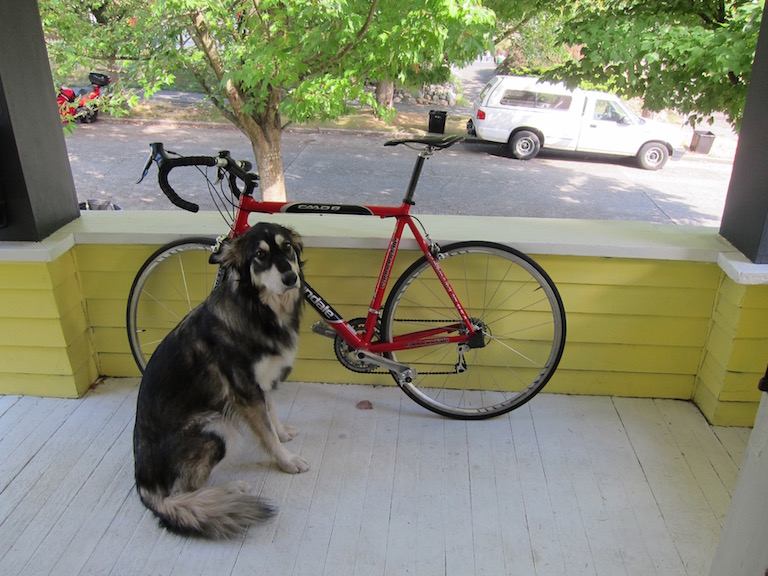

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

np.random.seed(0)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                    [[30, 61], [62, 45], [59, 119]],
                    [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('/content/drive/MyDrive/data/yolo.h5', '/content/drive/MyDrive/data/coco_classes.txt', 0.6, 0.5, anchors)
images, image_paths = yolo.load_images('/content/drive/MyDrive/data/yolo')
i = np.random.randint(0, len(images))
cv2_imshow(images[i])


# TASK 5

In [4]:
#!/usr/bin/env python3
"""
uses the Yolo v3 algorithm to perform object detection
"""
import tensorflow as tf
import numpy as np
import os
import cv2


class Yolo:
    """Yolo class to perform object detection using the YOLOv3 algorithm"""

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used
            for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score
            threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        anchors is a numpy.ndarray of shape (outputs, anchor_boxes, 2)
            ...containing all of the anchor boxes:
            outputs is the number of outputs (predictions)
                made by the Darknet model
            anchor_boxes is the number of anchor boxes used for each prediction
            2 => [anchor_box_width, anchor_box_height]
        Public instance attributes:
        model: the Darknet Keras model
        class_names: a list of the class names for the model
        class_t: the box score threshold for the initial filtering step
        nms_t: the IOU threshold for non-max suppression
        anchors: the anchor boxes
        """
        if not tf.keras.models.load_model(model_path):
            raise FileNotFoundError("Model not found at the provided path.")
        if not isinstance(anchors, np.ndarray) or anchors.shape[-1] != 2:
            raise ValueError(
                "Anchors must be a numpy.ndarray \
                of shape (outputs, anchor_boxes, 2)."
            )

        self.model = tf.keras.models.load_model(model_path)
        with open(classes_path, "r") as f:
            self.class_names = [line.strip() for line in f.readlines()]
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors

    def process_outputs(self, outputs, image_size):
        """
        Processes the outputs from the Darknet model for a single image.
        The nested loops iterate through each grid cell and anchor box to
            compute the processed boundary box coordinates.
        The loops handle the conversion of coordinates from the
            Darknet model's prediction to the
            coordinates relative to the original image.

        outputs: contains predictions from Darknet model for a single image
        i: used to access the corresponding anchor box dimensions
        output: the individual prediction array for processing

        :param outputs: list of numpy.ndarrays containing
            the predictions from the Darknet model for a single image
                Each output will have the shape (grid_height,
                    grid_width, anchor_boxes, 4 + 1 + classes),
                where:
                    - grid_height & grid_width: height
                        and width of the grid used for the output
                    - anchor_boxes: number of anchor boxes used
                    - 4: bounding box coordinates (t_x, t_y, t_w, t_h)
                    - 1: box_confidence
                    - classes: class probabilities for all classes
        :param image_size: numpy.ndarray containing the image’s
            original size [image_height, image_width]
        :return: tuple of (boxes, box_confidences, box_class_probs)
                - boxes: list of numpy.ndarrays of shape (grid_height,
                    grid_width, anchor_boxes, 4) containing the processed
                    boundary boxes for each output, respectively
                4 => (x1, y1, x2, y2) representing
                    the boundary box relative to original image
                - box_confidences: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, 1)
                    containing the box confidences for each output
                - box_class_probs: list of numpy.ndarrays of shape
                    (grid_height, grid_width, anchor_boxes, classes)
                    containing the box’s class probabilities for each output
        """
        boxes = []
        box_confidences = []
        box_class_probs = []

        for output_index, output in enumerate(outputs):
            grid_height, grid_width, anchor_boxes, _ = output.shape
            raw_boundary_box_coords = output[..., :4]
            rawBoxConfidence = output[..., 4:5]
            raw_box_class_probabilities = output[..., 5:]

            # Applying sigmoid activation to the box confidence
            box_confidence_after_sigmoid = 1 / (1 + np.exp(-rawBoxConfidence))
            box_confidences.append(box_confidence_after_sigmoid)

            # Applying sigmoid activation to the class probabilities
            box_class_probs_after_sigmoid = 1 / (
                1 + np.exp(-raw_box_class_probabilities)
            )
            box_class_probs.append(box_class_probs_after_sigmoid)

            for cell_y in range(grid_height):
                for cell_x in range(grid_width):
                    for anchor_box_index in range(anchor_boxes):
                        anchor_width, anchor_height = self.anchors[
                            output_index
                        ][anchor_box_index]
                        tx, ty, tw, th = raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ]

                        # Applying sigmoid activation and
                        #   offsetting by grid cell location
                        boundaryBoxCenter_x = (1 / (1 + np.exp(-tx))) + cell_x
                        boundaryBoxCenter_y = (1 / (1 + np.exp(-ty))) + cell_y

                        # Applying exponential and scaling by anchor dimensions
                        boundary_box_width = anchor_width * np.exp(tw)
                        boundary_box_height = anchor_height * np.exp(th)

                        # Normalizing by grid and model input dimensions
                        boundaryBoxCenter_x /= grid_width
                        boundaryBoxCenter_y /= grid_height
                        boundary_box_width /= int(self.model.input.shape[1])
                        boundary_box_height /= int(self.model.input.shape[2])

                        # Converting to original image scale
                        top_left_x = (
                            boundaryBoxCenter_x - (boundary_box_width / 2)
                        ) * image_size[1]
                        top_left_y = (
                            boundaryBoxCenter_y - (boundary_box_height / 2)
                        ) * image_size[0]
                        bottom_right_x = (
                            boundaryBoxCenter_x + (boundary_box_width / 2)
                        ) * image_size[1]
                        bottom_right_y = (
                            boundaryBoxCenter_y + (boundary_box_height / 2)
                        ) * image_size[0]

                        # Storing the processed boundary box coordinates
                        raw_boundary_box_coords[
                            cell_y, cell_x, anchor_box_index
                        ] = [
                            top_left_x,
                            top_left_y,
                            bottom_right_x,
                            bottom_right_y,
                        ]

            boxes.append(raw_boundary_box_coords)

        return (boxes, box_confidences, box_class_probs)

    def filter_boxes(self, boxes, box_confidences, box_class_probs):
        """
        boxes: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, 4)
            containing processed boundary boxes for each output, respectively
        box_confidences: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, 1)
            containing processed box confidences for each output, respectively
        box_class_probs: a list of numpy.ndarrays of shape
            (grid_height, grid_width, anchor_boxes, classes)
            containing processed box class probabilities for each output

        Returns a tuple of (filtered_boxes, box_classes, box_scores):
            filtered_boxes: a numpy.ndarray of shape (?, 4)
                containing all of the filtered bounding boxes
            box_classes: a numpy.ndarray of shape (?,)
                containing the class number that each box
                in filtered_boxes predicts, respectively
            box_scores: a numpy.ndarray of shape (?)
                containing the box scores for each box
                in filtered_boxes, respectively
        """
        filtered_boxes = []
        box_classes = []
        box_scores = []

        # Iterate through each output
        for box, box_confidence, box_class_prob in zip(
            boxes, box_confidences, box_class_probs
        ):
            # Compute box scores by multiplying confidence w/ class probs
            scores = box_confidence * box_class_prob

            # Get the class index with the maximum score for each box
            box_class_indices = np.argmax(scores, axis=-1)
            box_class_scores = np.max(scores, axis=-1)

            # Create a mask for scores greater than the threshold
            filtering_mask = box_class_scores >= self.class_t

            # Apply the mask to filter the boxes, class indices, and scores
            filtered_boxes.append(box[filtering_mask])
            box_classes.append(box_class_indices[filtering_mask])
            box_scores.append(box_class_scores[filtering_mask])

        # Concatenate results from all outputs into single arrays
        filtered_boxes = np.concatenate(filtered_boxes)
        box_classes = np.concatenate(box_classes)
        box_scores = np.concatenate(box_scores)

        return (filtered_boxes, box_classes, box_scores)

    def non_max_suppression(self, filtered_boxes, box_classes, box_scores):
        """
        filtered_boxes: a numpy.ndarray of shape (?, 4)
            containing all of the filtered bounding boxes
        box_classes: a numpy.ndarray of shape (?,)
            containing the class number for the class that
            filtered_boxes predicts, respectively
        box_scores: a numpy.ndarray of shape (?)
            containing the box scores for each box in filtered_boxes

        Returns tuple
        (box_predictions, predicted_box_classes, predicted_box_scores):
            box_predictions: a numpy.ndarray of shape (?, 4)
            containing predicted bounding boxes ordered by class and box score
            predicted_box_classes: a numpy.ndarray of shape (?,)
                containing the class number for box_predictions
                ordered by class and box score, respectively
            predicted_box_scores: a numpy.ndarray of shape (?)
                containing the box scores for box_predictions
                ordered by class and box score, respectively
        """
        # Concatenate box classes and box scores to sort them together
        box_classes = box_classes.astype(int).reshape(-1, 1)
        box_scores = box_scores.reshape(-1, 1)
        boxes_with_classes_and_scores = np.concatenate(
            (filtered_boxes, box_classes, box_scores), axis=1
        )

        # Sort boxes by class and scores
        sortedBoxes = boxes_with_classes_and_scores[
            np.lexsort((box_scores.ravel(), box_classes.ravel()))
        ]

        # Pre-allocate result arrays
        box_predictions = []
        predicted_box_classes = []
        predicted_box_scores = []

        # Iterate through unique classes
        unique_classes = np.unique(sortedBoxes[:, -2])
        for unique_class in unique_classes:
            # Get boxes of the same class
            same_class_boxes = sortedBoxes[sortedBoxes[:, -2] == unique_class]

            # Apply non-max suppression for the same class boxes
            while len(same_class_boxes) > 0:
                # Take the box with the highest score
                best_box = same_class_boxes[-1]
                box_predictions.append(best_box[:4])
                predicted_box_classes.append(best_box[4])
                predicted_box_scores.append(best_box[5])

                # Remove the best box
                same_class_boxes = same_class_boxes[:-1]

                # Compute IoU with the best box using vectorized operations
                x1 = np.maximum(same_class_boxes[:, 0], best_box[0])
                y1 = np.maximum(same_class_boxes[:, 1], best_box[1])
                x2 = np.minimum(same_class_boxes[:, 2], best_box[2])
                y2 = np.minimum(same_class_boxes[:, 3], best_box[3])

                intersection_area = np.maximum(0, x2 - x1) * np.maximum(
                    0, y2 - y1
                )
                best_box_area = (best_box[2] - best_box[0]) * (
                    best_box[3] - best_box[1]
                )
                current_boxes_area = (
                    same_class_boxes[:, 2] - same_class_boxes[:, 0]
                ) * (same_class_boxes[:, 3] - same_class_boxes[:, 1])
                union_area = (
                    best_box_area + current_boxes_area - intersection_area
                )

                iou = intersection_area / union_area

                # Remove boxes with IoU greater than the threshold
                same_class_boxes = same_class_boxes[iou < self.nms_t]

        predicted_box_classes = np.array(predicted_box_classes).astype(int)
        return (
            np.array(box_predictions).astype(int),
            predicted_box_classes,
            np.array(predicted_box_scores),
        )

    @staticmethod
    def load_images(folder_path):
        """
        Loads images from a given folder path.

        :param folder_path: a string representing the path to the folder holding all the images to load
        :return: a tuple of (images, image_paths), where
            - images: a list of images as numpy.ndarrays
            - image_paths: a list of paths to the individual images in images
        """
        images = []
        image_paths = []
        for filename in os.listdir(folder_path):
            path = os.path.join(folder_path, filename)
            if os.path.isfile(path):
                image = cv2.imread(path)
                if image is not None:
                    images.append(image)
                    image_paths.append(path)

        return images, image_paths

    def preprocess_images(self, images):
        """Preprocesses the input images for the YOLO model."""
        input_h = self.model.input.shape[1]
        input_w = self.model.input.shape[2]

        # List for holding preprocessed images
        pimages = []

        # List for holding original image shapes
        image_shapes = []

        for image in images:
            # Store original shape
            image_shapes.append(image.shape[:2])

            # Resize and normalize the image in one step
            pimage = cv2.resize(image, (input_h, input_w),
                                interpolation=cv2.INTER_CUBIC) / 255.0

            pimages.append(pimage)

        # Convert lists to numpy arrays
        pimages = np.array(pimages)
        image_shapes = np.array(image_shapes)

        return pimages, image_shapes


<class 'numpy.ndarray'> (6, 416, 416, 3)
<class 'numpy.ndarray'> (6, 2)
(500, 500, 3) : [500 500]


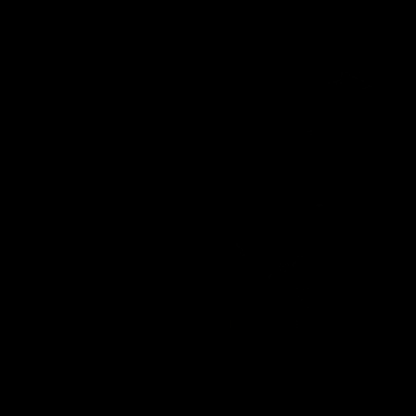

In [3]:
#!/usr/bin/env python3

from google.colab.patches import cv2_imshow

if __name__ == '__main__':
    import cv2
    import numpy as np

    np.random.seed(0)
    anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
    yolo = Yolo('/content/drive/MyDrive/data/yolo.h5', '/content/drive/MyDrive/data/coco_classes.txt', 0.6, 0.5, anchors)
    images, image_paths = yolo.load_images('/content/drive/MyDrive/data/yolo')
    pimages, image_shapes = yolo.preprocess_images(images)
    print(type(pimages), pimages.shape)
    print(type(image_shapes), image_shapes.shape)
    i = np.random.randint(0, len(images))
    print(images[i].shape, ':', image_shapes[i])
    cv2_imshow(pimages[i])
